In [1]:
import os
import re
import sys
import time
import shutil
import copy
import glob
import numpy as np
import itertools
import importlib
import multiprocessing
import multiprocessing.pool
import fnmatch
import segyio
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
from skimage import restoration
from scipy import signal, ndimage
from natsort import natsorted
import seaborn as sns
sys.path.append(('./utils'))
import mgen
import datasetmaker
import shared as sd
import loaders as ld
import vis

from IPython.display import clear_output

# remove the sys.path... line and add pyapi_denise.py to the same directory with the notebook
sys.path.append(os.path.abspath('../'))
import pyapi_denise as api

print(f'Python: {sys.prefix}')

Python: /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/env


In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# mpl.rcParams['figure.dpi']= 100
fontsize = 10
params = {
    # 'text.latex.preamble': ['\\usepackage{gensymb}'],
    # 'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'figure.dpi' : 150,
    # 'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize':fontsize,  # fontsize for x and y labels (was 10)
    'axes.titlesize':fontsize,
    'font.size':fontsize,  # was 10
    'legend.fontsize': fontsize,  # was 10
    'xtick.labelsize':fontsize,
    'ytick.labelsize':fontsize,
    # 'text.usetex': True,
    # 'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
mpl.rcParams.update(params)

In [3]:
#     cmap = 'gist_ncar'
def is_empty(p): return False if (os.path.exists(p) and [f for f in os.listdir(p) if f != '.gitignore']) else True

def divmax(x): return x / np.max(np.abs(x))
    
def load_bin(p, dims): 
    f = open(p); vp = np.fromfile (f, dtype=np.dtype('float32').newbyteorder ('<')); f.close();
    vp = vp.reshape(*dims); vp = np.transpose(vp); vp = np.flipud(vp); print(f"{vp.shape}"); return vp

def plot_model(v, title='', axis='on', **kwargs): 
    plt.figure(); ax = plt.gca(); im = ax.imshow(np.flipud(v), cmap='RdBu_r', **kwargs); plt.axis(axis); plt.title(title); 
    divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05);plt.colorbar(im, cax=cax); plt.pause(0.001)
    return ax

def plot_logs(m1, m2, idx=2, title=''):
    plt.figure(); plt.plot(m1.vp[::-1,idx], 'k--'); plt.plot(m1.vs[::-1,idx], 'k--'); plt.plot(m1.rho[::-1,idx], 'k--');
    plt.plot(m2.vp[::-1,idx], label='vp'); plt.plot(m2.vs[::-1,idx], label='vs'); plt.plot(m2.rho[::-1,idx], label='rho'); plt.legend() 
def extend(x, ez, ex):
    if ex > 0:
        x = np.concatenate((x, np.flip(x[:, -ex:], -1)), 1)              # OX
    if ez > 0:
        x = np.concatenate((x, x.min() * np.ones((ez, x.shape[1]))), 0)  # OZ
    return x
def plot_log_model(mm, dx, nx, nz0, _src):
    v = mm.copy() / 1000
    plt.figure(); ax = plt.gca();
    map_src = _src.x / dx < nx
    plt.scatter(_src.x[map_src]/1000, _src.y[map_src]/1000, 1, color='w'); 
    cmap='RdBu_r'
    im = ax.imshow(v[:,:nx0], cmap=cmap, extent=[0, nx0 * dx / 1000, 0, nz0 * dx/1000], 
                   origin='upper', vmin=1.45, vmax=3.5); 
    divider = make_axes_locatable(ax); 
    cax = divider.append_axes("right", size="5%", pad=0.05); cbar = plt.colorbar(im, cax=cax); cbar.set_label('km/s');
    ax.set_xlabel('km'); ax.set_ylabel('km'); ax.set_title(f); ax.invert_yaxis();

    log = model_log.vp[:, log_idx]
    vh = 420*dx * np.ones_like(log)/ 1000 
    ax.plot(vh, np.arange(len(log))*dx/1000, 'k--')
    ax.plot(vh + (log[::-1] - min(log)) / 1000, np.arange(len(log))*dx/1000, 'k')
    plt.pause(0.001)

In [4]:

root_fwi = './out_ac/'
root_out = '/data/oleg/data/'
root_field = os.path.join('./data_cgg/')
# Data loading
# data_paths='/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_fwi_strategy_13_dsrc_200_pseudo_field_nx_496'
# data_paths='/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_fwi_strategy_13_dsrc_200_pseudo_field_nx_496_test4'
data_paths=[
            '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_fwi_strategy_13_dsrc_200_pseudo_field_nx_496',
            '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_fwi_strategy_13_dsrc_200_pseudo_field_nx_496_test4']
data_paths=['/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_above_water_better_scaling']
dx=25;dz=25
########################## find directories in the folder
files=[]
for data_path in data_paths:
    tmp=fnmatch.filter(os.listdir(data_path),'*.npz')
    for file_ in tmp:
        path_=os.path.join(data_path,file_)
        files.append(path_)
##########################
# files=fnmatch.filter(os.listdir(data_path),'*.npz')
test = fnmatch.filter(files, '*__*')
train=list(set(files)-set(test))
# test=list(set(test)-set(fnmatch.filter(files, '*_bad_initial*')))
# train=train[0:100]
print(len(files))
print(test)
print(len(train+test))

4084
['/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_above_water_better_scaling/model__Marmousi.npz', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_above_water_better_scaling/model__Seam_linear_initial.npz', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_above_water_better_scaling/model__Overthrust.npz', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_above_water_better_scaling/model__Seam.npz', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_above_water_better_scaling/model__Marmousi_linear_initial.npz', '/home/plotnips

In [5]:
from functools import partial
def unpack_file(NAME):
    pts=NAME.split('/')
    f_name=pts[-1]
    f_name=f_name[:-4]; 
    # print('reading ',f_name)
    with open(NAME, 'rb') as f:
        data=np.load(f)
        model=data['models'].squeeze()
        initial_model=data['models_init'].squeeze()
        input_data=data['input_data'].squeeze()
        output_data=data['output_data'].squeeze()
        input_data_real_amplitudes=data['input_data_real_amplitudes'].squeeze()
        output_data_real_amplitudes=data['output_data_real_amplitudes'].squeeze()
        data.close()
    fwi_result=input_data_real_amplitudes+initial_model
    data_structure={'model':model.T,'initial_model':initial_model.T,'input_data':input_data.T,'input_data_real_amplitudes':input_data_real_amplitudes.T
        ,'output_data_real_amplitudes':output_data_real_amplitudes.T,'name':f_name,'output_data':output_data.T,'fwi_result':fwi_result.T}
    # Plot_image(M0.T,Show_flag=0,Save_flag=1,Save_pictures_path=Save_pictures_path,Title=f_name+'_M0',Aspect='equal')
    # Plot_image(M2.T,Show_flag=0,Save_flag=1,Save_pictures_path=Save_pictures_path,Title=f_name+'_M2',Aspect='equal')
    return data_structure
def extract_structure_field(list_of_structures,field):
    list_of_arrays=[]
    for i in range(len(list_of_structures)):
        list_of_arrays.append( list_of_structures[i][field] )
    return list_of_arrays

flag_single_thread_processing=0
LIST=test
test_models_data=[]
dataset_models_data=[]
if flag_single_thread_processing == 1:
    for NAME in test:
        data_structure=unpack_file(NAME)
        test_models_data.append(data_structure)
        # test_models_data.append([model,initial_model])
    # print(test_models_data[0]['input_data'])
elif flag_single_thread_processing==0:
    pool = multiprocessing.Pool(multiprocessing.cpu_count()-5)
    temp = partial(unpack_file)
    test_models_data = pool.map(func=temp, iterable=test)
    pool.close()
    pool.join()
    pool = multiprocessing.Pool(multiprocessing.cpu_count()-5)
    temp = partial(unpack_file)
    dataset_models_data = pool.map(func=temp, iterable=train)
    pool.close()
    pool.join()

In [6]:
fwi_result_test=            extract_structure_field(test_models_data,'fwi_result')
x_ra=       extract_structure_field(test_models_data,'input_data_real_amplitudes')
t_ra=       extract_structure_field(test_models_data,'output_data_real_amplitudes')
test_models_model=          extract_structure_field(test_models_data,'model')
test_models_initial_model=extract_structure_field(test_models_data,'initial_model')
# for ii in test:
#     print(ii.split('/')[-1])
# for f in fwi_result_test:
#     print('fwi_result_test=',np.min(f),np.max(f))
# for f in x_ra:
#     print('x_ra=',np.min(f),np.max(f))
# for f in t_ra:
#     print('t_ra=',np.min(f),np.max(f))
# for f in test_models_model:
#     print('model=',np.min(f),np.max(f))
# for f in test_models_initial_model:
#     print('init model=',np.min(f),np.max(f))

In [7]:
# pars = {'data_mode': 'cnn1'};pars.update({'taper_shift':200})

fwi_result_train=extract_structure_field(dataset_models_data,'fwi_result')
fwi_result_train=np.asarray(fwi_result_train,dtype=np.float32)

other_models_inp_data=extract_structure_field(dataset_models_data,'input_data_real_amplitudes')
other_models_inp_data=np.asarray(other_models_inp_data,dtype=np.float32)

other_models=extract_structure_field(dataset_models_data,'model')
other_models=np.asarray(other_models,dtype=np.float32)

other_models_initial_model=extract_structure_field(dataset_models_data,'initial_model')
other_models_initial_model=np.asarray(other_models_initial_model,dtype=np.float32)

input_data=np.asarray(extract_structure_field(dataset_models_data,'input_data'),dtype=np.float32)
output_data=np.asarray(extract_structure_field(dataset_models_data,'output_data'),dtype=np.float32)

other_models_output_data=extract_structure_field(dataset_models_data,'output_data_real_amplitudes')
other_models_output_data=np.asarray(other_models_output_data,dtype=np.float32)


print('fwi_result_train.min())',fwi_result_train.min())
print('fwi_result_train.max())',fwi_result_train.max())
print('other_models_inp_data.min())',other_models_inp_data.min())
print('other_models_inp_data.max())',other_models_inp_data.max())
print('other_models_initial_model.min())',other_models_initial_model.min())
print('other_models_initial_model.max())',other_models_initial_model.max())
print('other_models.min())',other_models.min())
print('other_models.max())',other_models.max())
print('x.min',input_data.min(),'x.max',input_data.max())
print('t.min',output_data.min(),'t.max',output_data.max())
print('other_models_output_data.min())',other_models_output_data.min())
print('other_models_output_data.max())',other_models_output_data.max())
print('other_models_output_data.min())',np.min(other_models_output_data))
print('other_models_output_data.max())',np.max(other_models_output_data))
print(other_models_output_data.shape)

fwi_result_train.min()) 1500.0
fwi_result_train.max()) 4495.7993
other_models_inp_data.min()) -1515.8442
other_models_inp_data.max()) 1131.9597
other_models_initial_model.min()) 1500.0
other_models_initial_model.max()) 4159.6963
other_models.min()) 1500.0
other_models.max()) 4700.0
x.min -0.94740266 x.max 0.7074748
t.min -0.6514135 t.max 0.9651009
other_models_output_data.min()) -1758.8164
other_models_output_data.max()) 2605.7725
other_models_output_data.min()) -1758.8164
other_models_output_data.max()) 2605.7725
(4074, 150, 496)


In [8]:
dist_x_ra = np.max(np.abs(other_models_inp_data), axis=(1,2))
dist_x = np.max(np.abs(input_data), axis=(1,2))

dist_t_ra = np.max(np.abs(other_models_output_data), axis=(1,2))
dist_t = np.max(np.abs(output_data), axis=(1,2))

In [9]:
# dist_x_ra=other_models_inp_data.flatten()
# dist_x=input_data.flatten()
# dist_t_ra=other_models_output_data.flatten()
# dist_t=output_data.flatten()

val=1000000
val=1000
dist_x_ra=dist_x_ra[0:val]
dist_x=dist_x[0:val]
dist_t_ra=dist_t_ra[0:val]
dist_t=dist_t[0:val]
print(dist_x_ra.shape)

(1000,)


In [10]:
def plot_hist(dist):
    sns.set(style='whitegrid', 
#         palette="deep", 
    palette="Blues_r", 
    rc={"figure.figsize": [7, 5]})
    plt.figure()
    title='dist_x_ra; mean,std='+str(np.mean(dist))+','+str(np.std(dist)) 
    sns.histplot(dist, kde=False, stat='count', 
                    color = 'navy',
                    alpha = 0.85,bins=100,
                     line_kws={ 'color': 'k', 'linestyle': 'dashed', 'linewidth': 2},
                     binrange=(np.min(dist), np.max(dist)),
                    #  binrange=(-250, 250),
                    ).set(xlabel='Velocity perturbation, km / s', ylabel='Count',title=title,
                #             ylim=[0,max_count],
                    xlim=[np.min(dist), np.max(dist)])

min(dist_x_ra),max(dist_x_ra) 1.2338867 1515.8442


[Text(0.5, 0, 'Velocity perturbation, km / s'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'dist_t_ra; mean,std=927.1808,368.1081'),
 (163.212890625, 2207.21142578125)]

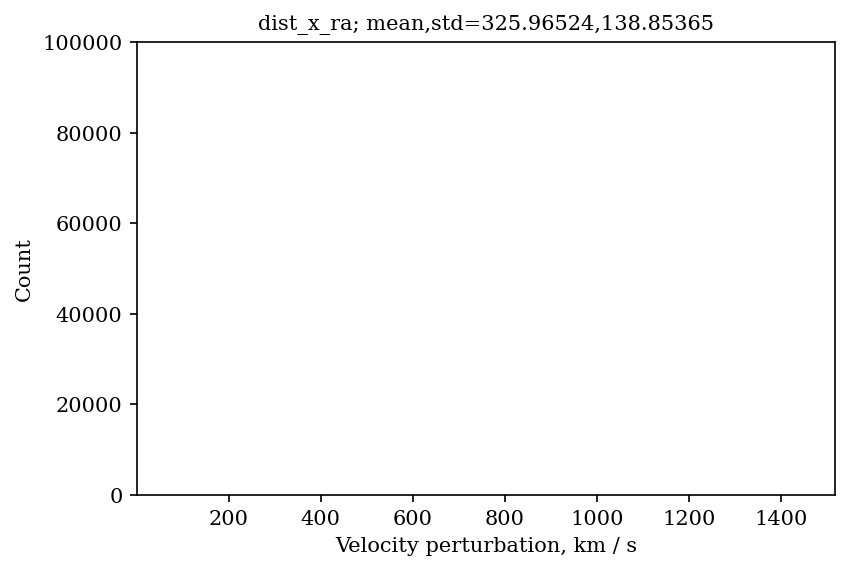

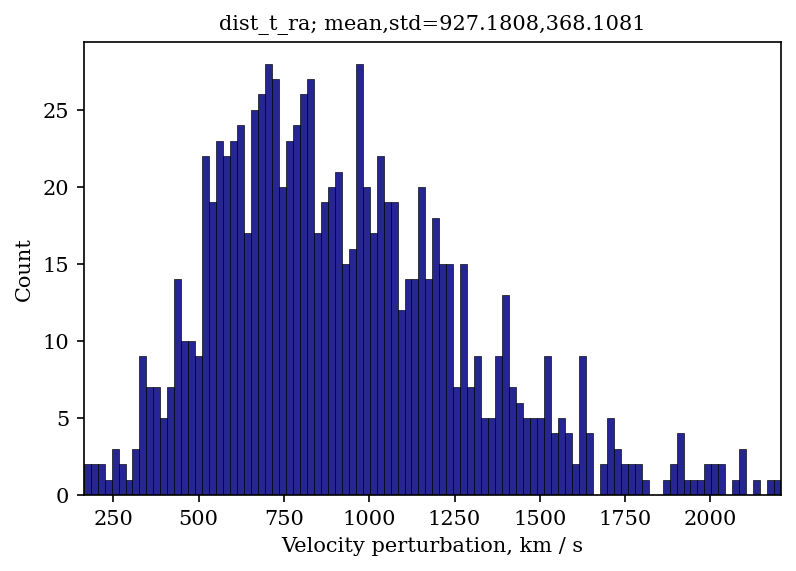

In [11]:
print('min(dist_x_ra),max(dist_x_ra)',np.min(dist_x_ra),np.max(dist_x_ra))


max_count=100000
plt.figure();   dist=dist_x_ra
title='dist_x_ra; mean,std='+str(np.mean(dist))+','+str(np.std(dist)) 
sns.histplot(dist, kde=False, stat='count', 
            color = 'navy',
            alpha = 0.85,bins=100,
             line_kws={ 'color': 'k', 'linestyle': 'dashed', 'linewidth': 2},
             binrange=(np.min(dist), np.max(dist)),
            #  binrange=(-250, 250),
            ).set(xlabel='Velocity perturbation, km / s', ylabel='Count',title=title,
            ylim=[0,max_count],
            xlim=[np.min(dist), np.max(dist)])
plt.figure();   dist=dist_t_ra
title='dist_t_ra; mean,std='+str(np.mean(dist))+','+str(np.std(dist)) 
sns.histplot(dist, kde=False, stat='count', 
            color = 'navy',
            alpha = 0.85,bins=100,
             line_kws={ 'color': 'k', 'linestyle': 'dashed', 'linewidth': 2},
             binrange=(np.min(dist), np.max(dist)),
            #  binrange=(-250, 250),
            ).set(xlabel='Velocity perturbation, km / s', ylabel='Count',title=title,
#                   ylim=[0,max_count],
            xlim=[np.min(dist), np.max(dist)])


## Remove outliers

### In input gradients

In [12]:
print(dist_x_ra.shape)
dist_x_ra_mask = (dist_x_ra > 100) & (dist_x_ra < 500)
dist_x_ra_filt = dist_x_ra[dist_x_ra_mask]
dist_t_ra_filt = dist_t_ra[dist_x_ra_mask]
print(dist_x_ra_filt.shape, dist_t_ra_filt.shape)
assert len(dist_x_ra_filt) == len(dist_t_ra_filt), 'Length of verctors must match!'
# dist_t_ra = np.max(np.abs(other_models_output_data), axis=(1,2))

(1000,)
(897,) (897,)


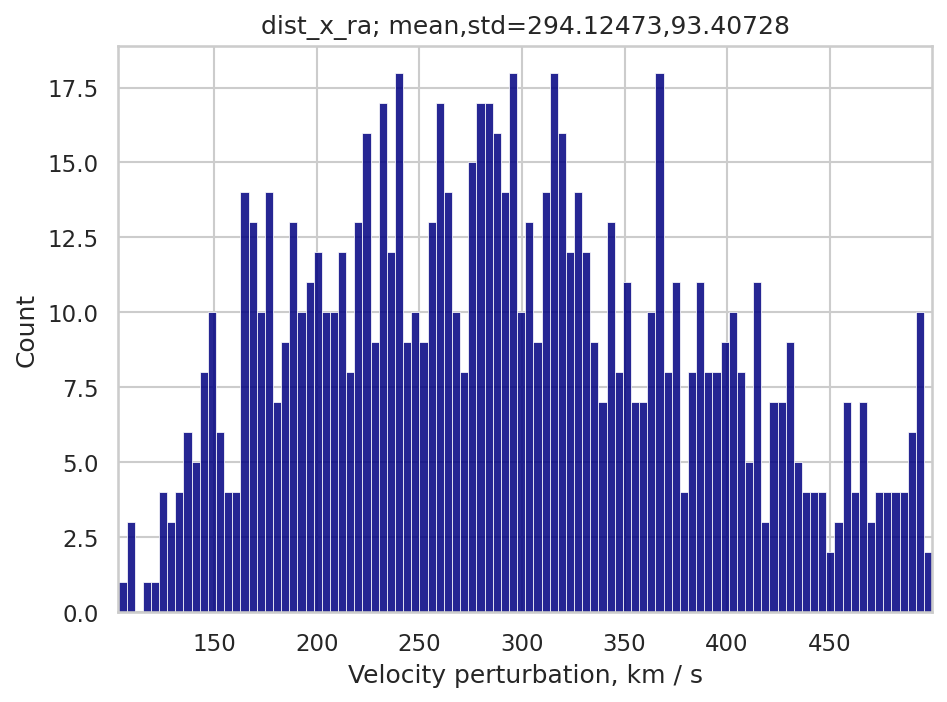

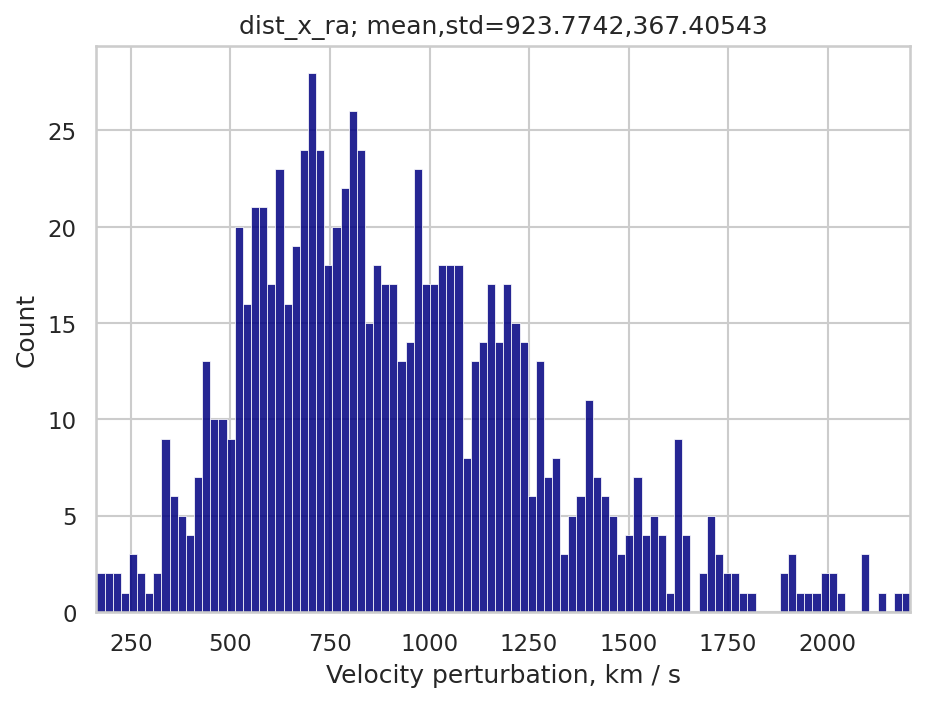

In [13]:
plot_hist(dist_x_ra_filt)
plot_hist(dist_t_ra_filt)

### In target gradients

In [14]:
print(dist_t_ra_filt.shape)
dist_t_ra_mask = (dist_t_ra_filt > 0) & (dist_t_ra_filt < 1750)

dist_x_ra_filt2 = dist_x_ra_filt[dist_t_ra_mask]
dist_t_ra_filt2 = dist_t_ra_filt[dist_t_ra_mask]
print(dist_x_ra_filt2.shape, dist_t_ra_filt2.shape)
assert len(dist_x_ra_filt2) == len(dist_t_ra_filt2), 'Length of verctors must match!'
# dist_t_ra = np.max(np.abs(other_models_output_data), axis=(1,2))

(897,)
(872,) (872,)


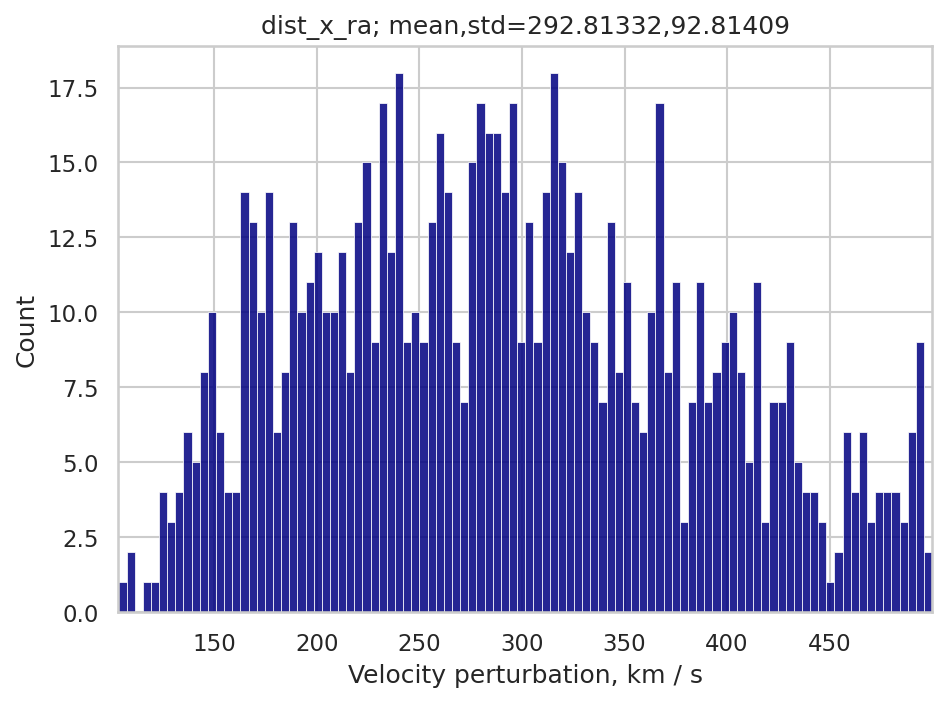

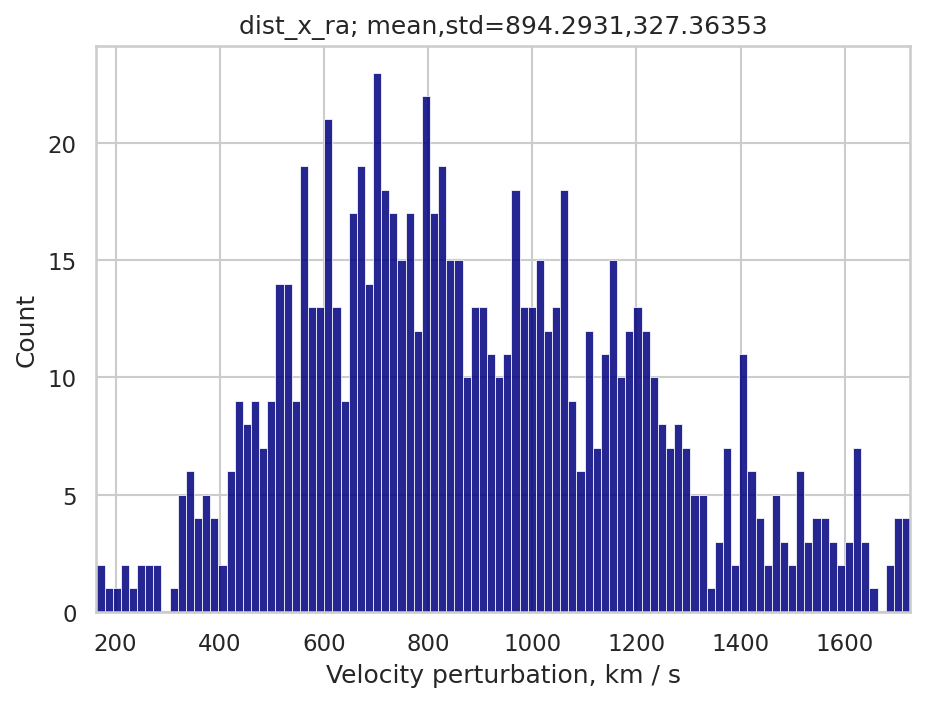

In [15]:
plot_hist(dist_x_ra_filt2)
plot_hist(dist_t_ra_filt2)

Final shape of training dataset is 

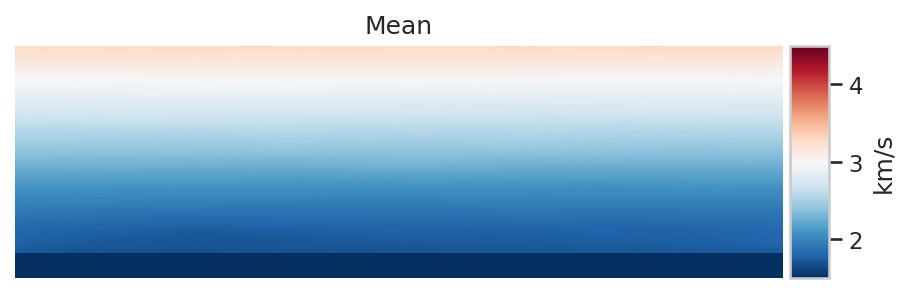

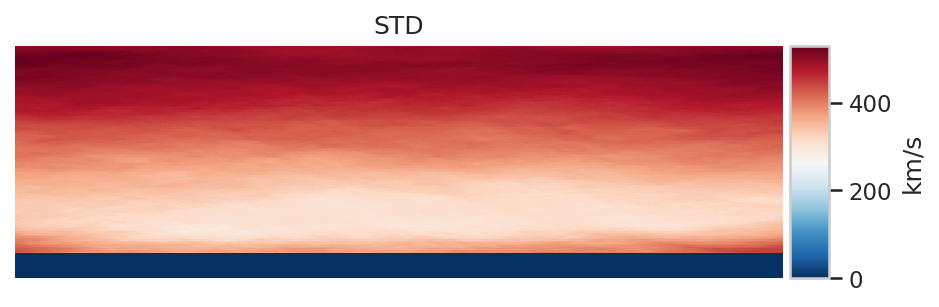

In [16]:
print
# Images
par_box = {'vmin': 1500, 'vmax': 4500}
par_box_km = {'vmin': 1.5, 'vmax': 4.5}
vis.plot_model(np.mean(other_models, 0) / 1000, title='Mean', axis='off', cax_label='km/s', 
#                colorbar=False,
               **par_box_km)
vis.plot_model(np.std(other_models, 0), title='STD', 
#                colorbar=False,
               axis='off')
# print(np.linspace(0, nmodels-1, 4))
# for i in [int(np.floor(x)) for x in np.linspace(0, nmodels-1, 4)]:
#     vis.plot_model(other_models[i], axis='off', colorbar=False, **par_box
# #                    title=f'Model {i+1} / {nmodels}'
#                   )

In [17]:
print(nmodels)
vol = np.concatenate([np.expand_dims(m, 0) for m in other_models], 0)
print(vol.shape)

NameError: name 'nmodels' is not defined

In [ ]:
# dist = np.mean((vol - np.mean(vol, keepdims=True))[:, :, log_idx], 1)
the_log = (vol - np.mean(vol, keepdims=True))[:, :, idx_dist] / 1000
print(the_log.shape)
dist = the_log[:, the_log.shape[-1] // 2]
print(dist.shape)

sns.set(style='whitegrid', 
#         palette="deep", 
        palette="Blues_r", 
        rc={"figure.figsize": [7, 5]})


sns.histplot(dist, kde=False, stat='count', 
            color = 'navy',
            alpha = 0.85,
             line_kws={ 'color': 'k', 'linestyle': 'dashed', 'linewidth': 2},
             binrange=(0.99 * np.min(dist), 0.9 * np.max(dist)),
            ).set(xlabel='Velocity perturbation, km / s', ylabel='Count');